# Intake-ESM Demo

## Import Packages

In [1]:
import warnings

warnings.filterwarnings("ignore")
import cmocean
import hvplot.xarray
import intake
import proplot as plot
import xarray as xr
from distributed import Client
from ncar_jobqueue import NCARCluster

xr.set_options(keep_attrs=True)
import cartopy.crs as ccrs
import cf_xarray
from cmip6_preprocessing.preprocessing import combined_preprocessing

## Create Dask Cluster

In [2]:
cluster = NCARCluster()
cluster.adapt(minimum_jobs=4, maximum_jobs=5)
client = Client(cluster)
cluster

## Open ESM data catalog

In [3]:
col = intake.open_esm_datastore(
    '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cmip6.json'
)
col

In [4]:
col.df.head()

activity_id institution_id source_id   experiment_id member_id table_id  \
0  AerChemMIP            BCC  BCC-ESM1  ssp370-lowNTCF  r1i1p1f1      day   
1  AerChemMIP            BCC  BCC-ESM1  ssp370-lowNTCF  r1i1p1f1      day   
2  AerChemMIP            BCC  BCC-ESM1  ssp370-lowNTCF  r2i1p1f1      day   
3  AerChemMIP            BCC  BCC-ESM1  ssp370-lowNTCF  r2i1p1f1      day   
4  AerChemMIP            BCC  BCC-ESM1  ssp370-lowNTCF  r3i1p1f1      day   

  variable_id grid_label  dcpp_init_year    version         time_range  \
0        rsds         gn             NaN  v20190624  20150101-20551231   
1      tasmax         gn             NaN  v20190624  20150101-20551231   
2        rsds         gn             NaN  v20190624  20150101-20551231   
3      tasmax         gn             NaN  v20190624  20150101-20551231   
4        rsds         gn             NaN  v20190624  20150101-20551231   

                                                path  
0  /glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...  
1  /glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...  
2  /glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...  
3  /glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...  
4  /glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...

## Run query against the catalog

In [5]:
variable = 'fgco2'
query = dict(
    experiment_id=['esm-piControl', 'historical'],
    table_id='Omon',
    variable_id=variable,
    grid_label=['gr'],
)
cat = col.search(**query)
cat

## Load Data into xarray datasets

In [6]:
dset_dict = cat.to_dataset_dict(
    cdf_kwargs={'chunks': {'time': 600}, 'use_cftime': True}, preprocess=combined_preprocessing
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [7]:
[key for key in dset_dict.keys()]

['CMIP.NOAA-GFDL.GFDL-ESM4.esm-piControl.Omon.gr',
 'CMIP.NCAR.CESM2.esm-piControl.Omon.gr',
 'CMIP.NCAR.CESM2-WACCM.historical.Omon.gr',
 'CMIP.NCAR.CESM2.historical.Omon.gr',
 'CMIP.NCAR.CESM2-FV2.historical.Omon.gr',
 'CMIP.NOAA-GFDL.GFDL-CM4.historical.Omon.gr',
 'CMIP.NCAR.CESM2-WACCM-FV2.historical.Omon.gr',
 'CMIP.MRI.MRI-ESM2-0.historical.Omon.gr',
 'CMIP.NOAA-GFDL.GFDL-ESM4.historical.Omon.gr']

In [8]:
dset_dict['CMIP.NCAR.CESM2.esm-piControl.Omon.gr']

<xarray.Dataset>
Dimensions:        (bnds: 2, member_id: 1, time: 6000, vertex: 4, x: 360, y: 180)
Coordinates: (12/13)
  * time           (time) object 0001-01-15 13:00:00 ... 0500-12-15 12:00:00
    time_bounds    (time, bnds) object dask.array<chunksize=(600, 2), meta=np.ndarray>
  * y              (y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bounds     (y, bnds, x) float64 dask.array<chunksize=(180, 2, 360), meta=np.ndarray>
  * x              (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    lon_bounds     (x, bnds, y) float64 dask.array<chunksize=(360, 2, 180), meta=np.ndarray>
    ...             ...
    lon            (x, y) float64 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
    lat            (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    lon_verticies  (vertex, x, y) float64 dask.array<chunksize=(1, 360, 180), meta=np.ndarray>
    lat_verticies  (vertex, x, y) float64 dask.array<chunksize=(1, 360, 180), meta=np.ndarray>
  * vertex         (vertex) int64 0 1 2 3
  * member_id      (member_id) <U8 'r1i1p1f1'
Data variables:
    fgco2          (member_id, time, y, x) float32 dask.array<chunksize=(1, 600, 180, 360), meta=np.ndarray>
Attributes: (12/46)
    source_id:               CESM2
    frequency:               mon
    activity_id:             CMIP
    experiment:              A pre-industrial control simulation with non-evo...
    mip_era:                 CMIP6
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    ...                      ...
    table_id:                Omon
    cesm_casename:           b.e21.B1850.f09_g17.CMIP6-esm-piControl.001
    parent_source_id:        CESM2
    nominal_resolution:      1x1 degree
    sub_experiment:          none
    intake_esm_dataset_key:  CMIP.NCAR.CESM2.esm-piControl.Omon.gr

## Compute and visualize spatial means 

In [9]:
%%time
means = {key: ds.mean(['time', 'member_id']).squeeze().compute() for key, ds in dset_dict.items()}

CPU times: user 942 ms, sys: 115 ms, total: 1.06 s
Wall time: 8.04 s


CPU times: user 6.59 s, sys: 23.4 ms, total: 6.61 s
Wall time: 6.63 s


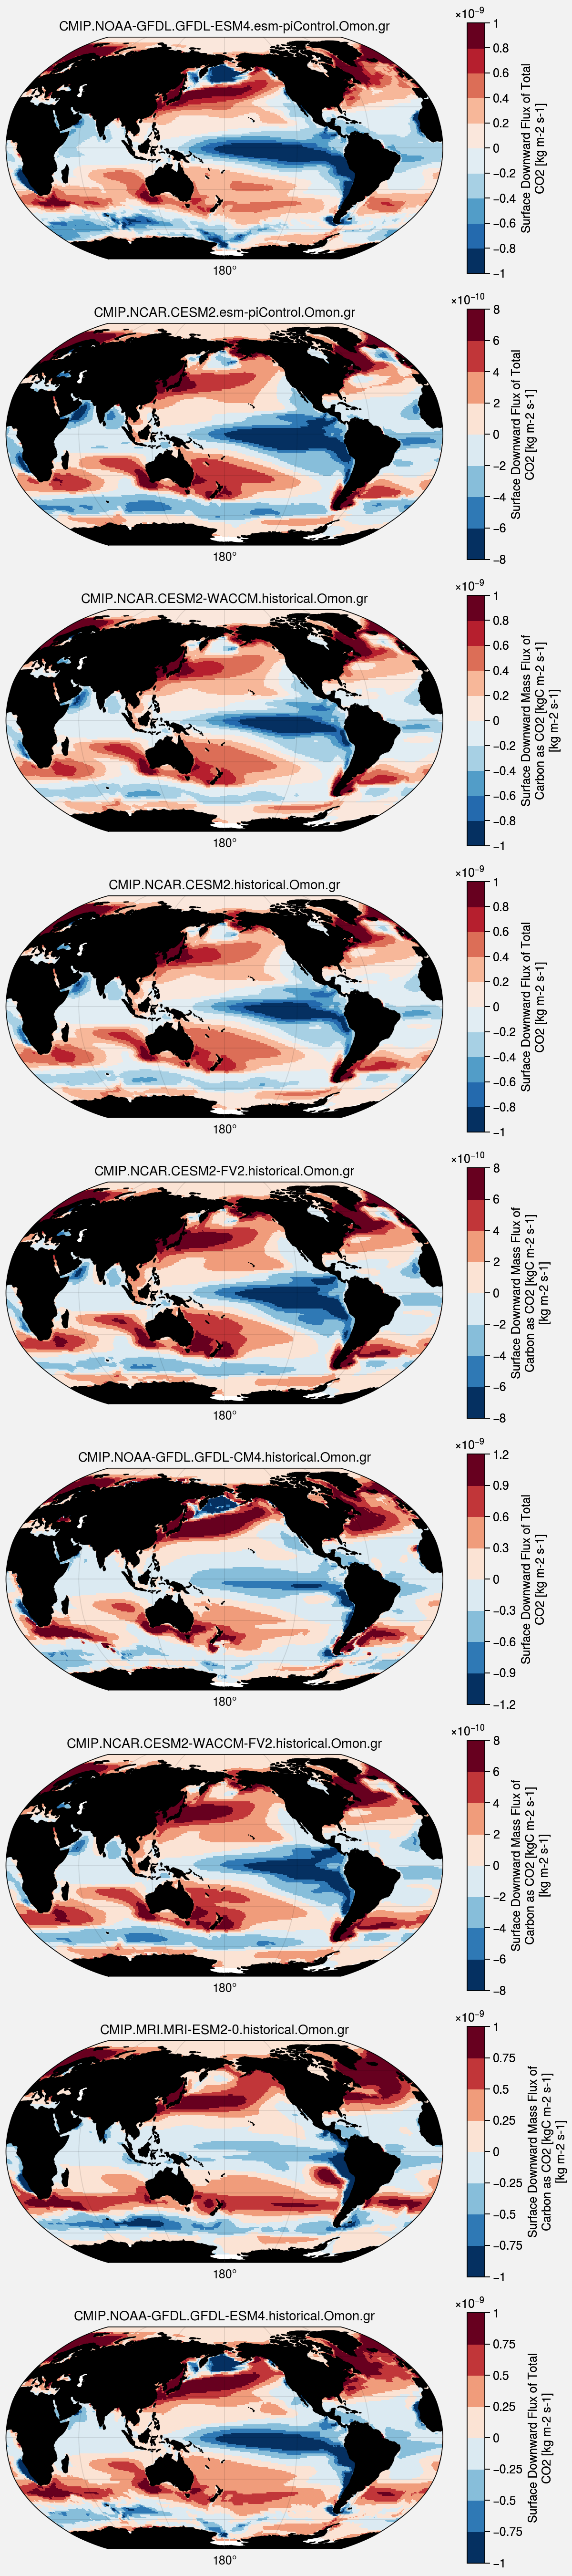

In [10]:
%%time
fig, axes = plot.subplots(
    nrows=len(dset_dict), figsize=[6, 3 * len(dset_dict)], proj='robin', proj_kw={'lon_0': 180}
)
for index, (key, ds) in enumerate(means.items()):
    assert len(ds[variable].dims) == 2
    ds[variable].plot(ax=axes[index], robust=True, transform=ccrs.PlateCarree(), cmap='RdBu_r')
    axes[index].format(title=key)

axes.format(land=True, coast=True, lonlabels=True)

## Run additional queries against the catalog

In [11]:
cat = col.search(
    variable_id='tas',
    table_id='Amon',
    experiment_id=['historical'],
    grid_label=['gn'],
    institution_id='NCAR',
)
cat

## Load found data assets into xarray datasets

In [12]:
dset_dict = cat.to_dataset_dict(
    cdf_kwargs={'chunks': {'time': 200}, 'use_cftime': True}, preprocess=combined_preprocessing
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [13]:
[key for key in dset_dict.keys()]

['CMIP.NCAR.CESM2-WACCM-FV2.historical.Amon.gn',
 'CMIP.NCAR.CESM2.historical.Amon.gn',
 'CMIP.NCAR.CESM2-WACCM.historical.Amon.gn',
 'CMIP.NCAR.CESM2-FV2.historical.Amon.gn']

## Compute and visualize annual means

In [14]:
means = {
    key: ds.cf.mean(['longitude', 'latitude'])['tas']
    .groupby('time.year')
    .mean(['time', 'member_id'])
    for key, ds in dset_dict.items()
}

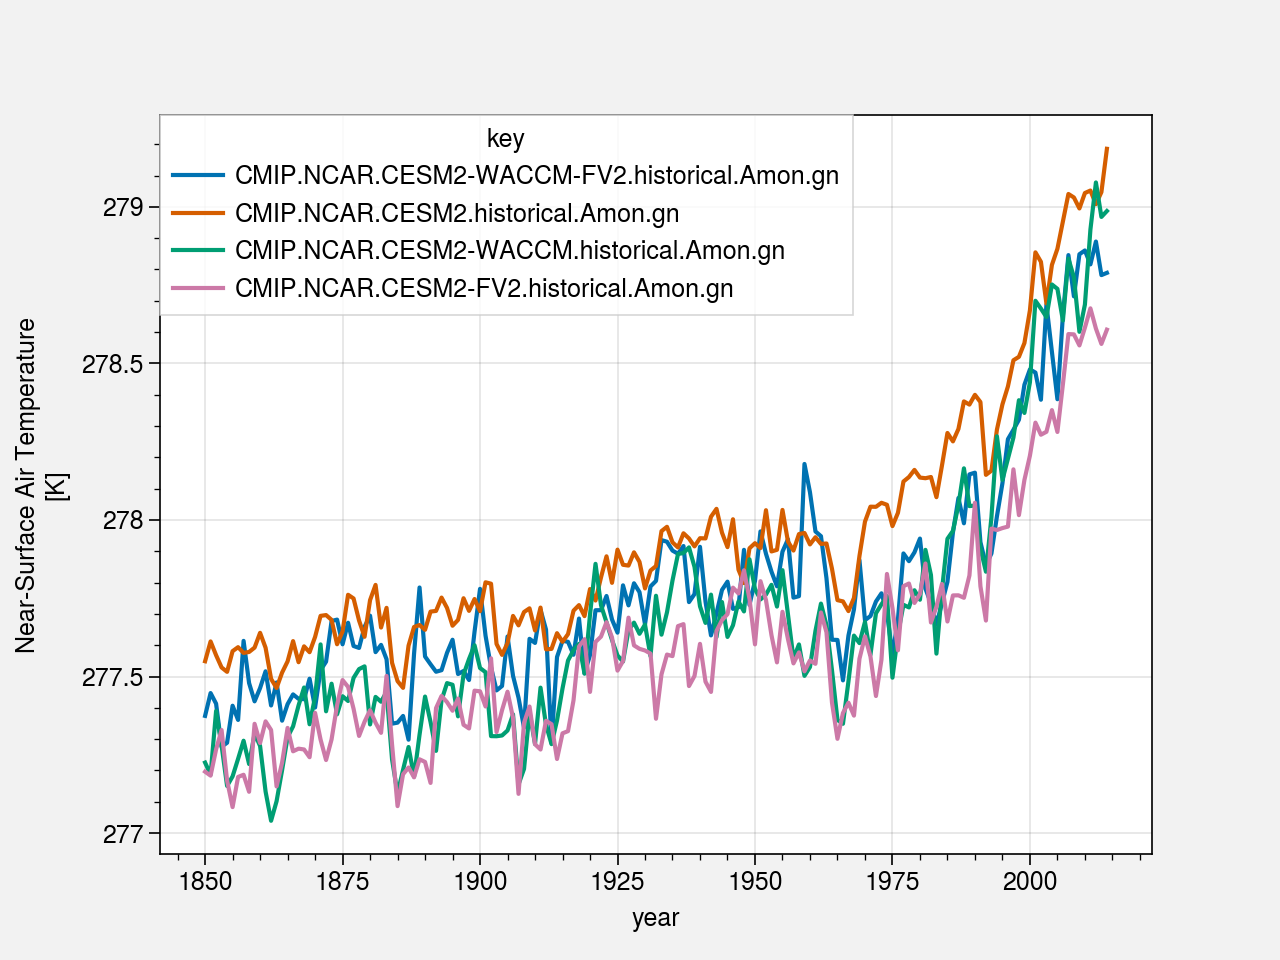

In [15]:
ds = xr.concat(list(means.values()), 'key', compat='override', coords='minimal')
ds['key'] = list(means.keys())
ds.plot.line(hue='key');